In [31]:
import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from collections import defaultdict
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [32]:
login= pd.read_json('logins.json')
print(login.head())

           login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21


In [33]:
data= json.load(open('ultimate_data_challenge.json'))
data=pd.DataFrame(data)
print(data.head())


   avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0      3.67                   5.0                   4.7       1.10   
1      8.26                   5.0                   5.0       1.00   
2      0.77                   5.0                   4.3       1.00   
3      2.36                   4.9                   4.6       1.14   
4      3.13                   4.9                   4.4       1.19   

             city last_trip_date    phone signup_date  surge_pct  \
0  King's Landing     2014-06-17   iPhone  2014-01-25       15.4   
1         Astapor     2014-05-05  Android  2014-01-29        0.0   
2         Astapor     2014-01-07   iPhone  2014-01-06        0.0   
3  King's Landing     2014-06-29   iPhone  2014-01-10       20.0   
4      Winterfell     2014-03-15  Android  2014-01-27       11.8   

   trips_in_first_30_days  ultimate_black_user  weekday_pct  
0                       4                 True         46.2  
1                       0                False

## Part 1 ‑ Exploratory data analysis

Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [34]:
login.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [35]:
login.set_index('login_time', inplace=True)
login['login'] = 1

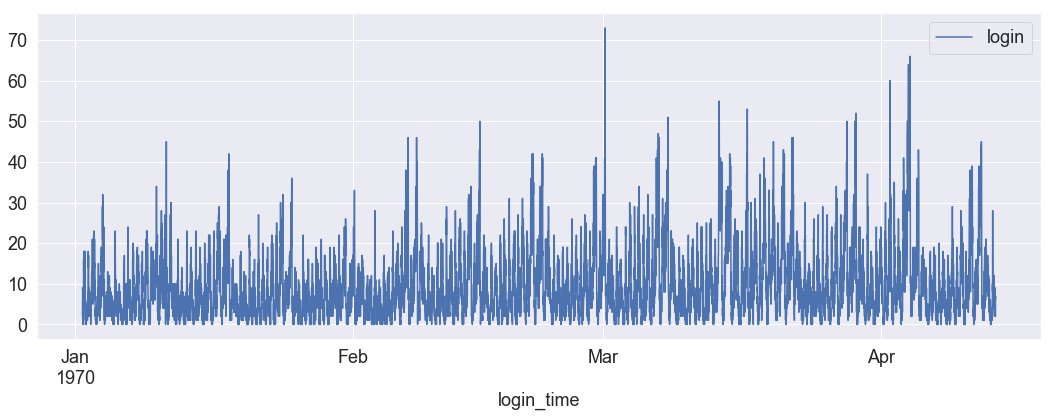

In [36]:
login.resample('15T').sum().plot()
sns.set(rc={"figure.figsize": (18, 6), 'legend.fontsize': 18})
plt.rc('axes' , labelsize=18)                                  # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)                                  # fontsize of the tick labels
plt.rc('ytick', labelsize=18)                                  # fontsize of the tick labels
plt.rc('axes' , titlesize=18)  
plt.show()

There are interesting spike trends in the data. The pattern seems repetative within each month. We can breakdown further into one month to take a closer look into the trend.

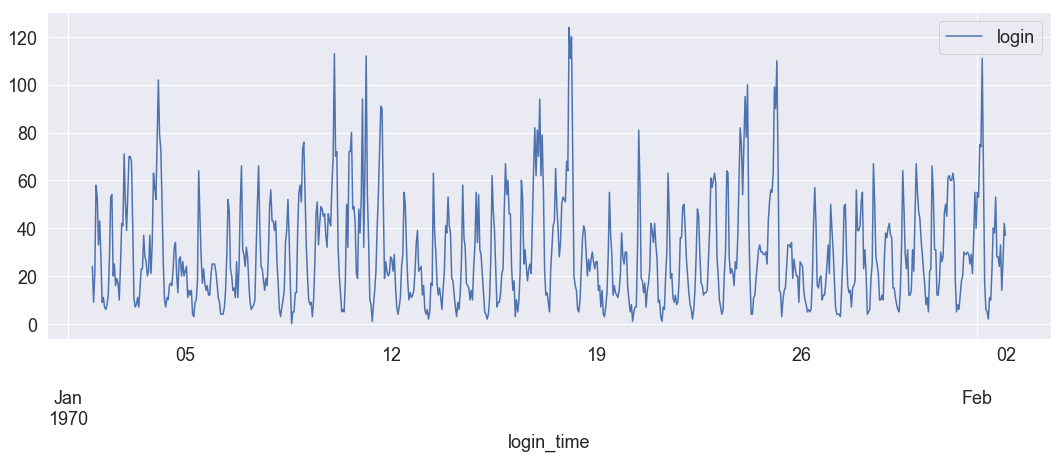

In [37]:
login.resample('1H').sum()['1970-01-01':'1970-02-01'].plot()
plt.show()

There are clear daily trends in the one month frame plot. Some days have higher logins.

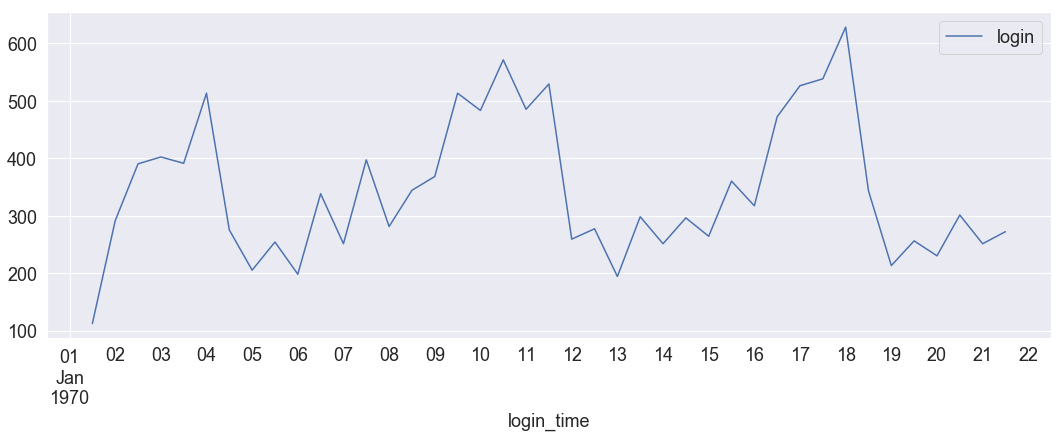

In [38]:
login.resample('12H').sum()['1970-01-01':'1970-01-21'].plot()
plt.show()

The three week cycle shows clear 3 spikes, which could be the weekends. The spikes are all a wekek apart.

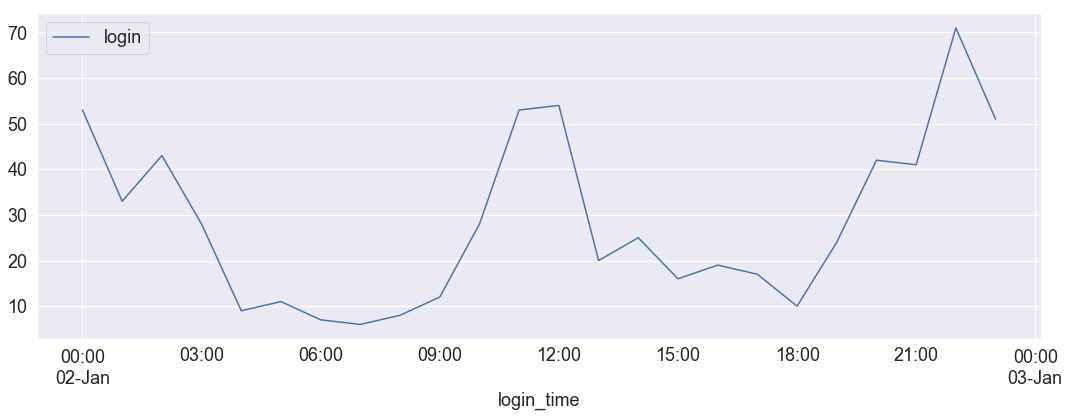

In [39]:
login.resample('1H').sum()['1970-01-02':'1970-01-02'].plot()
plt.show()

Based on the daily cycle, there are more logins in around noon and at night after 6 pm and before 3 am in the morning.

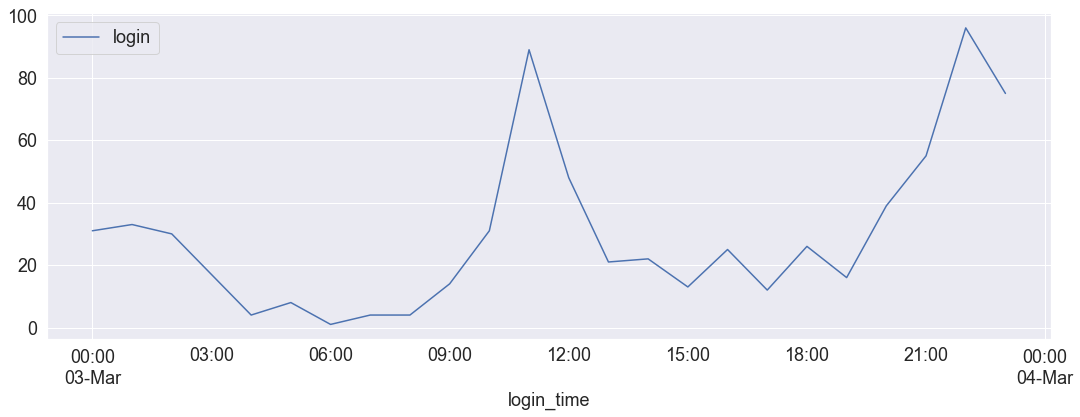

In [40]:
login.resample('1H').sum()['1970-03-03':'1970-03-03'].plot()
plt.show()

The same daily trends repeat at a nother random date: high logins in around noon and at night after 6 pm and before 3 am in the morning.

## Part 2 ‑ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?

Since drivers in both cities are exclusive to the home city, we can safely assume that driver in Gotham will have 100% of the trip in Gotham, and the same goes fro Metropilis.

If the goal is to make drivers from both cities availble to the other city, then a good metric would be that after the experiment, the drive from the domestic city has increased percentage of trips in the other city, and the ideal percentage would be equal to 50%.

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:<br>
a. how you will implement the experiment<br>
b. what statistical test(s) you will conduct to verify the significance of the observation<br>
c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

We need control data, percentage of trip in domestic and foreign city before the expereiment. Essentially, this will be T test. And after the commence of the experiment, we will need to collect the trip data. Depending on the time duration of the control data, we can collect post experiment data for the same length of time frame. We should give enough time to collect enough data for comparison and analysis.     

We can use two sample T test or Ztest to do the statistical testing. The key indicator we will be comparing is the percentage of trips in each city by each drive over the entire testing period, or calculate the percentage by day over all the drivers. We also need to give a $p$-value (say at $\alpha$=0.01 or 0.05) to potentially indicate a significant change in the indicator. 

Assuming there is a significant change after expriement. We could see positive change, where more drivers are now in the city other than their primary. However, we have to estimate the amount of revenue that exact change has brought and compare it to the cost of the program (remember Ultimate is paying the tolls!). This ratio metric is time agnostic, ignoring weekdays, weekends, day or night. A further iteration of this analysis would also include this (by perhaps binning in time) to see if perhaps there are certain times when the program is being used more than others.

## Part 3 ‑ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

In [41]:
data= json.load(open('ultimate_data_challenge.json'))
data=pd.DataFrame(data)
print(data.head())

   avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0      3.67                   5.0                   4.7       1.10   
1      8.26                   5.0                   5.0       1.00   
2      0.77                   5.0                   4.3       1.00   
3      2.36                   4.9                   4.6       1.14   
4      3.13                   4.9                   4.4       1.19   

             city last_trip_date    phone signup_date  surge_pct  \
0  King's Landing     2014-06-17   iPhone  2014-01-25       15.4   
1         Astapor     2014-05-05  Android  2014-01-29        0.0   
2         Astapor     2014-01-07   iPhone  2014-01-06        0.0   
3  King's Landing     2014-06-29   iPhone  2014-01-10       20.0   
4      Winterfell     2014-03-15  Android  2014-01-27       11.8   

   trips_in_first_30_days  ultimate_black_user  weekday_pct  
0                       4                 True         46.2  
1                       0                False

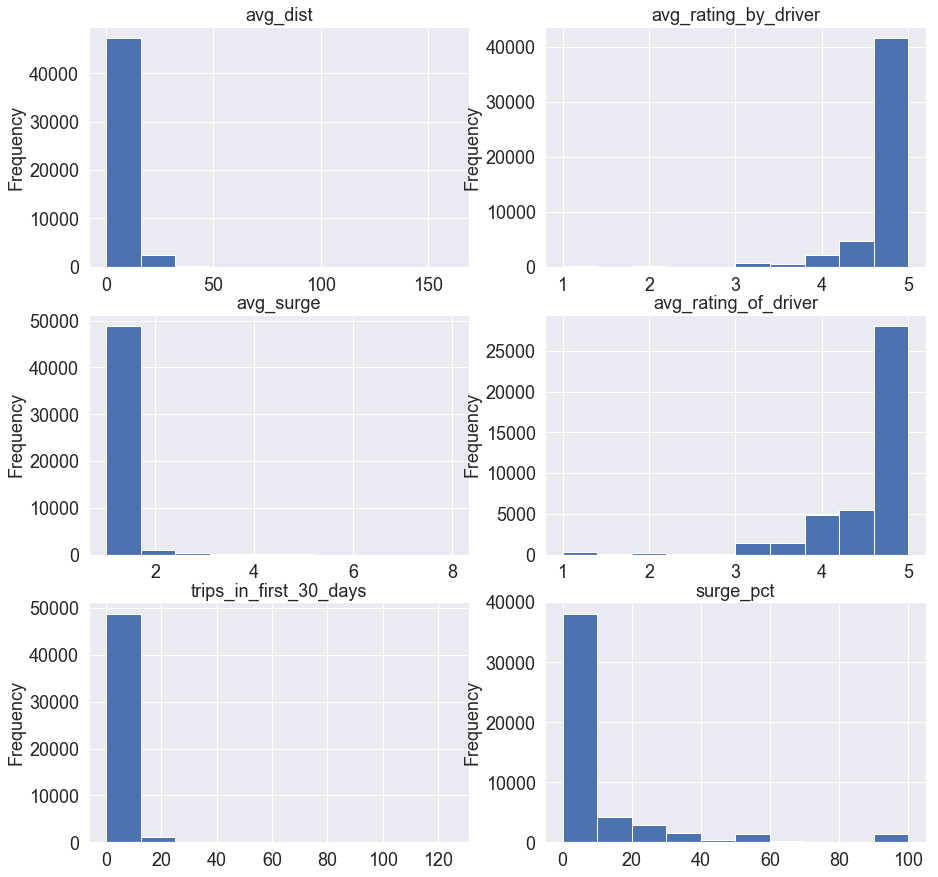

In [42]:
f, axs = plt.subplots(3,2,figsize=(15,15))
plt.subplot(3, 2, 1)
data['avg_dist'].plot(kind='hist', title='avg_dist')
plt.subplot(3, 2, 2)
data['avg_rating_by_driver'].plot(kind='hist', title='avg_rating_by_driver')
plt.subplot(3, 2, 3)
data['avg_surge'].plot(kind='hist', title='avg_surge')
plt.subplot(3, 2, 4)
data['avg_rating_of_driver'].plot(kind='hist', title='avg_rating_of_driver')
plt.subplot(3, 2, 5)
data['trips_in_first_30_days'].plot(kind='hist', title='trips_in_first_30_days')
plt.subplot(3, 2, 6)
data['surge_pct'].plot(kind='hist', title='surge_pct')

plt.show()

In [43]:
data.sort_values(by='last_trip_date',ascending=False).head()


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
4486,11.94,5.0,5.0,1.00,Winterfell,2014-07-01,Android,2014-01-25,0.0,4,True,25.0
43047,5.49,4.7,5.0,1.01,King's Landing,2014-07-01,iPhone,2014-01-15,0.8,1,True,89.3
24059,8.62,4.9,4.3,1.11,Astapor,2014-07-01,iPhone,2014-01-24,14.3,1,False,71.4
40290,7.51,4.8,4.9,1.02,King's Landing,2014-07-01,iPhone,2014-01-07,1.6,2,True,95.2
28689,16.32,5.0,5.0,1.00,King's Landing,2014-07-01,iPhone,2014-01-16,0.0,5,False,75.0


It looks like the current date is July first and well look into how many any active drivers are there in June.

In [44]:
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41445 entries, 0 to 41444
Data columns (total 12 columns):
avg_dist                  41445 non-null float64
avg_rating_by_driver      41445 non-null float64
avg_rating_of_driver      41445 non-null float64
avg_surge                 41445 non-null float64
city                      41445 non-null object
last_trip_date            41445 non-null object
phone                     41445 non-null object
signup_date               41445 non-null object
surge_pct                 41445 non-null float64
trips_in_first_30_days    41445 non-null int64
ultimate_black_user       41445 non-null bool
weekday_pct               41445 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 3.5+ MB


In [45]:
from datetime import datetime

In [46]:
retainperc=sum(pd.to_datetime(data['last_trip_date'])>pd.to_datetime('2014-06-01'))/len(data['trips_in_first_30_days'])
print(retainperc)

0.40072385088671736


About 40% driver are retained after 6 months.

2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.

We will first create a new feature as the target feature, which will be whether yes or no (1 or 0) the driver will be active in the 6th month.

In [47]:
data['target']=[int(val) for val in pd.to_datetime(data['last_trip_date'])>pd.to_datetime('2014-06-01')]

In [48]:
print(data.head())

   avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0      3.67                   5.0                   4.7       1.10   
1      8.26                   5.0                   5.0       1.00   
2      0.77                   5.0                   4.3       1.00   
3      2.36                   4.9                   4.6       1.14   
4      3.13                   4.9                   4.4       1.19   

             city last_trip_date    phone signup_date  surge_pct  \
0  King's Landing     2014-06-17   iPhone  2014-01-25       15.4   
1         Astapor     2014-05-05  Android  2014-01-29        0.0   
2         Astapor     2014-01-07   iPhone  2014-01-06        0.0   
3  King's Landing     2014-06-29   iPhone  2014-01-10       20.0   
4      Winterfell     2014-03-15  Android  2014-01-27       11.8   

   trips_in_first_30_days  ultimate_black_user  weekday_pct  target  
0                       4                 True         46.2       1  
1                       0     

In [49]:
data.drop(['last_trip_date', 'signup_date'], axis=1, inplace=True)

In [83]:
x=data.drop('target', axis=1)
y = data['target'].values
X=pd.get_dummies(x, drop_first=False)
df_columns = data.drop('target', axis=1).columns.values

In [67]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=10, stratify=y)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)
score_func = make_scorer(roc_auc_score, greater_is_better=True)

In [68]:
#Setup the RF object
rf = RandomForestClassifier(criterion='gini', class_weight='balanced', n_jobs=-1)

#Hyperparameter grid
param_grid = {'n_estimators' : [40, 50, 60], 'min_samples_split' : [2, 3, 4], 
              'max_depth' : [4, 7, 10]}

#Setup the Gridsearch
rf_cv = GridSearchCV(rf, param_grid, cv=cv, scoring=score_func, verbose=1)

#Fit the data
rf_cv.fit(x_train, y_train)

#Print out the best model
print('Best RF Params: {}'.format(rf_cv.best_params_))
print('Best RF Score : %f' % rf_cv.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  1.2min finished


Best RF Params: {'max_depth': 10, 'min_samples_split': 4, 'n_estimators': 60}
Best RF Score : 0.770644


In [71]:
rf_best = RandomForestClassifier(criterion='gini', class_weight='balanced', n_jobs=-1, 
                                 n_estimators=rf_cv.best_params_['n_estimators'],
                                 min_samples_split=rf_cv.best_params_['min_samples_split'], 
                                 max_depth=rf_cv.best_params_['max_depth'])

rf_best.fit(x_train, y_train)

#Print the score/metric for the input model which must be fit
def get_scores(model, name='unk', score=roc_auc_score):
    
    #Make prediction for the model
    pred = model.predict(x_test)
    pred_prob = model.predict_proba(x_test)[:,1]

    #Calculate the score on the entire test set
    auc = score(y_test, pred_prob)
    
    #Calculate the score on CV test set
    cv_scores = cross_val_score(model, x_test, y_test, cv=cv, scoring=score_func)
    mean_cv = cv_scores.mean()
    std_cv = cv_scores.std()
    
    #Save to dataframe to be used for printing only
    model_score = pd.DataFrame(columns=['Model', 'Test score', 'CV score'])
    model_score.loc[0] = [name, auc, mean_cv]
    model_score.set_index('Model', inplace=True)
    print(model_score)

In [72]:
get_scores(rf_best, 'RF')

       Test score  CV score
Model                      
RF       0.858924  0.772913


In [75]:
def plot_feature_importances(df):
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
   
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances by RandomForest Classifier')
    plt.show()
    
    return df

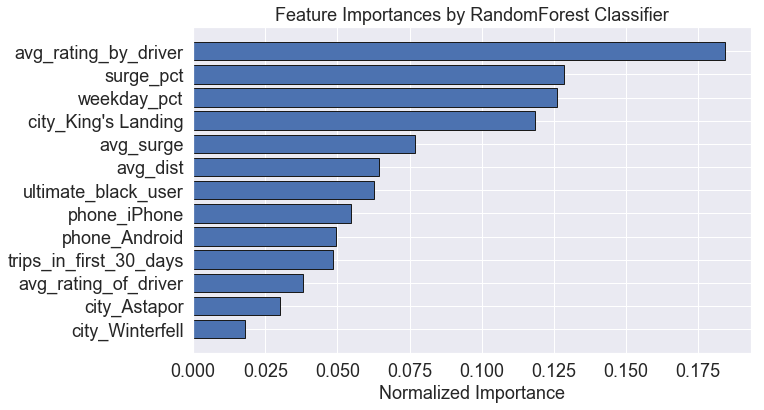

In [76]:
importance = rf_best.feature_importances_
feature = X.columns
fi = pd.DataFrame()
fi['importance'] = importance
fi['feature'] = feature
fi_sorted = plot_feature_importances(fi)

From the feature importances, we can see that the two most important predictors are the avg_rating_by_driver and surge_pct. This makes sense, because a high surge_pct means lots of using the Ultimate service. Coupled with an emphasis on the rating by the driver, and the high volume users tend to stay on the service. This is confirmed by the weekday_pct being the fourth highest predictor. It means users who also use Ultimate during the weekend, tend to use it all the time, thereby increasing their chances of being retained.

Ultimate can try to take advantage of this info in a few ways. Users from Winterfell tend to not be retained, at all, so perhaps do some marketing/PR for those people. There might also be a message to drivers to treat their customers better so their driver rating goes up. That might help with users wanting to use Ultimate more often, as they view drivers more positively.